In [10]:
import os
import sys
sys.path.append('../')
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

In [3]:
RAW_DATA_DIR = '../data/raw/'
INSTANCES_DIR = '../data/instances/'
INFERENCE_DIR = '../data/inference/'
STATES = ['normal', 
          'backlash1', 'backlash2',
          'lackLubrication1', 'lackLubrication2',
          'spalling1', 'spalling2', 'spalling3', 'spalling4',
          'spalling5', 'spalling6', 'spalling7', 'spalling8']
LOADS= ['20kg', '40kg', '-40kg']
SMOOTHING_PE_WINDOW_SIZE = 20
SMOOTHING_CUR_WINDOW_SIZE1 = 5
SMOOTHING_CUR_WINDOW_SIZE2 = 10
SMOOTHING_CUR_WINDOW_SIZE3 = 15

In [4]:
all_instances = {str(load) + '_' + str(state): os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES for load in LOADS}
num_instances = 0
for k, v in all_instances.items():
    num_instances += len(v)
    print(f"Total number of instances for {k}: {len(v)}")
print(f"Total number of instances: {num_instances}")

Total number of instances for 20kg_normal: 40
Total number of instances for 40kg_normal: 40
Total number of instances for -40kg_normal: 40
Total number of instances for 20kg_backlash1: 40
Total number of instances for 40kg_backlash1: 36
Total number of instances for -40kg_backlash1: 40
Total number of instances for 20kg_backlash2: 40
Total number of instances for 40kg_backlash2: 40
Total number of instances for -40kg_backlash2: 40
Total number of instances for 20kg_lackLubrication1: 40
Total number of instances for 40kg_lackLubrication1: 40
Total number of instances for -40kg_lackLubrication1: 40
Total number of instances for 20kg_lackLubrication2: 40
Total number of instances for 40kg_lackLubrication2: 40
Total number of instances for -40kg_lackLubrication2: 40
Total number of instances for 20kg_spalling1: 40
Total number of instances for 40kg_spalling1: 40
Total number of instances for -40kg_spalling1: 40
Total number of instances for 20kg_spalling2: 40
Total number of instances for 

In [5]:
normal_20kg = all_instances['20kg_normal']

In [11]:
import random

random.seed(42)
rand_filename = os.path.join(INSTANCES_DIR, '20kg', 'normal', random.choice(normal_20kg))
rand_file_df = pd.read_csv(rand_filename)
rand_file_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   set_point       324 non-null    float64
 1   position_error  324 non-null    float64
 2   current         324 non-null    float64
dtypes: float64(3)
memory usage: 7.7 KB


## Smoothing by Moving Average

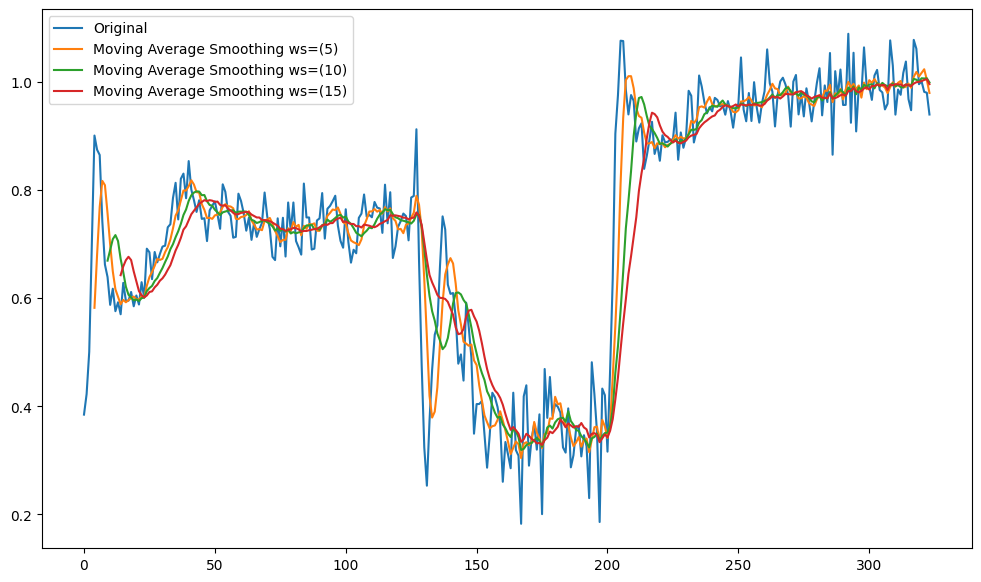

In [9]:
plt.figure(figsize=(12, 7))
plt.plot(rand_file_df['current'])
plt.plot(rand_file_df['current'].rolling(SMOOTHING_CUR_WINDOW_SIZE1).mean())
plt.plot(rand_file_df['current'].rolling(SMOOTHING_CUR_WINDOW_SIZE2).mean())
plt.plot(rand_file_df['current'].rolling(SMOOTHING_CUR_WINDOW_SIZE3).mean())
plt.legend(['Original', 
            f'Moving Average Smoothing ws=({SMOOTHING_CUR_WINDOW_SIZE1})', 
            f'Moving Average Smoothing ws=({SMOOTHING_CUR_WINDOW_SIZE2})',
            f'Moving Average Smoothing ws=({SMOOTHING_CUR_WINDOW_SIZE3})'])
plt.show()

## Smoothing by Exponential Moving Average

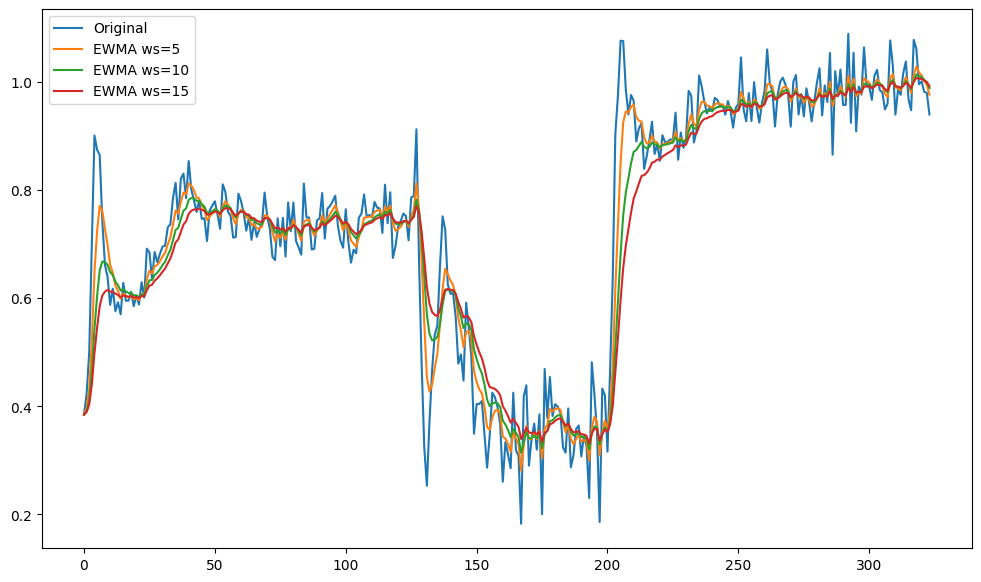

In [52]:
plt.figure(figsize=(12, 7))
plt.plot(rand_file_df['current'])
plt.plot(rand_file_df['current'].ewm(span=5, adjust=False).mean())
plt.plot(rand_file_df['current'].ewm(span=10, adjust=False).mean())
plt.plot(rand_file_df['current'].ewm(span=15, adjust=False).mean())
plt.legend(['Original', 'EWMA ws=5', 'EWMA ws=10', 'EWMA ws=15'])
plt.show()

## Smoothing by Gaussian Smoothing

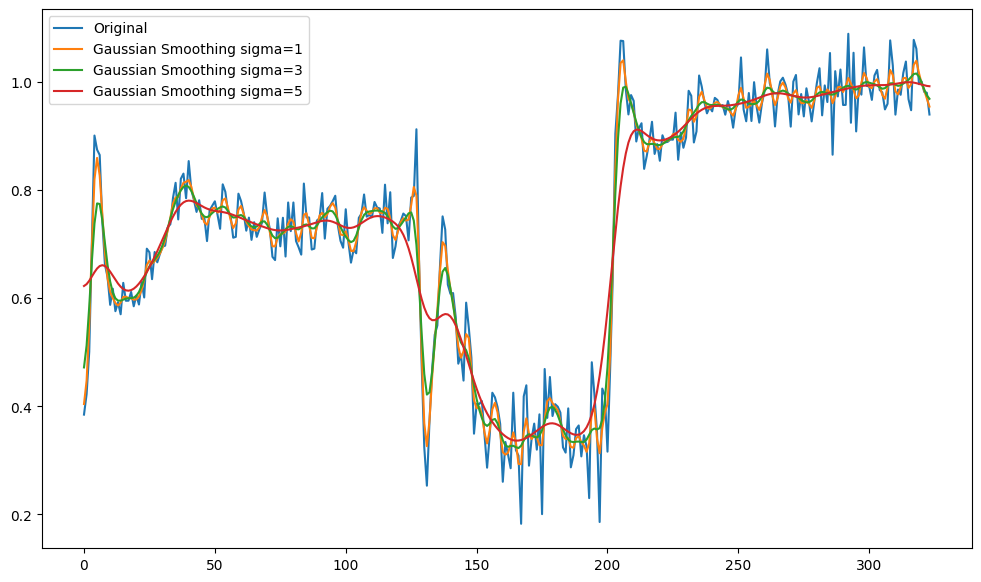

In [63]:
plt.figure(figsize=(12, 7))
plt.plot(rand_file_df['current'])
plt.plot(gaussian_filter1d(rand_file_df['current'], sigma=1))
plt.plot(gaussian_filter1d(rand_file_df['current'], sigma=2))
plt.plot(gaussian_filter1d(rand_file_df['current'], sigma=5))
plt.legend(['Original', 'Gaussian Smoothing sigma=1', 'Gaussian Smoothing sigma=3', 'Gaussian Smoothing sigma=5'])
plt.show()

## Smoothing by Savitzky-Golay Filter

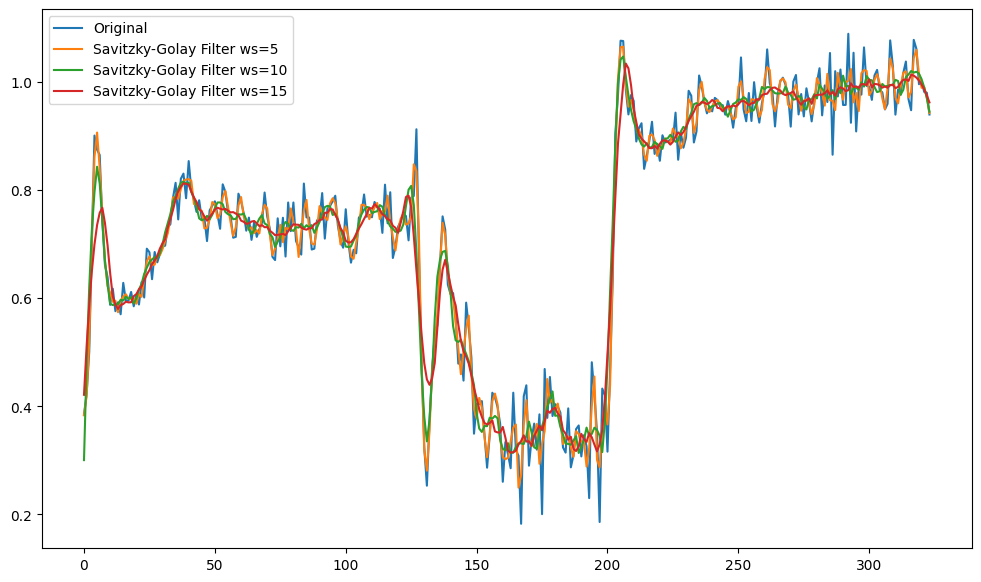

In [69]:
plt.figure(figsize=(12, 7))
plt.plot(rand_file_df['current'])
plt.plot(savgol_filter(rand_file_df['current'], window_length=5, polyorder=2))
plt.plot(savgol_filter(rand_file_df['current'], window_length=10, polyorder=2))
plt.plot(savgol_filter(rand_file_df['current'], window_length=15, polyorder=2))
plt.legend(['Original', 'Savitzky-Golay Filter ws=5', 'Savitzky-Golay Filter ws=10', 'Savitzky-Golay Filter ws=15'])
plt.show()

## Averaging all samples in one conditions

In [95]:
average_dict = {}
for k, v in all_instances.items():    
    load, state = k.split('_')
    # Average all current and position error of 20kgnormal
    if load == '20kg':
        all_files = all_instances[k]
        average_dict[k] = {'current': [], 'position_error': []}

        n_cur = len(pd.read_csv(os.path.join(INSTANCES_DIR, load, state, all_files[0]))['current'])
        n_pos_err = len(pd.read_csv(os.path.join(INSTANCES_DIR, load, state, all_files[0]))['position_error'])

        average_df = {'current': [0] * n_cur, 'position_error': [0] * n_pos_err}

        for filename in all_files:
            df = pd.read_csv(os.path.join(INSTANCES_DIR, load, state, filename))
            average_df['current'] += df['current']
            average_df['position_error'] += df['position_error']

        average_df['current'] = average_df['current'] / len(all_files)
        average_df['position_error'] = average_df['position_error'] / len(all_files)
        
        average_dict[k]['current'] = average_df['current'].tolist()
        average_dict[k]['position_error'] = average_df['position_error'].tolist()

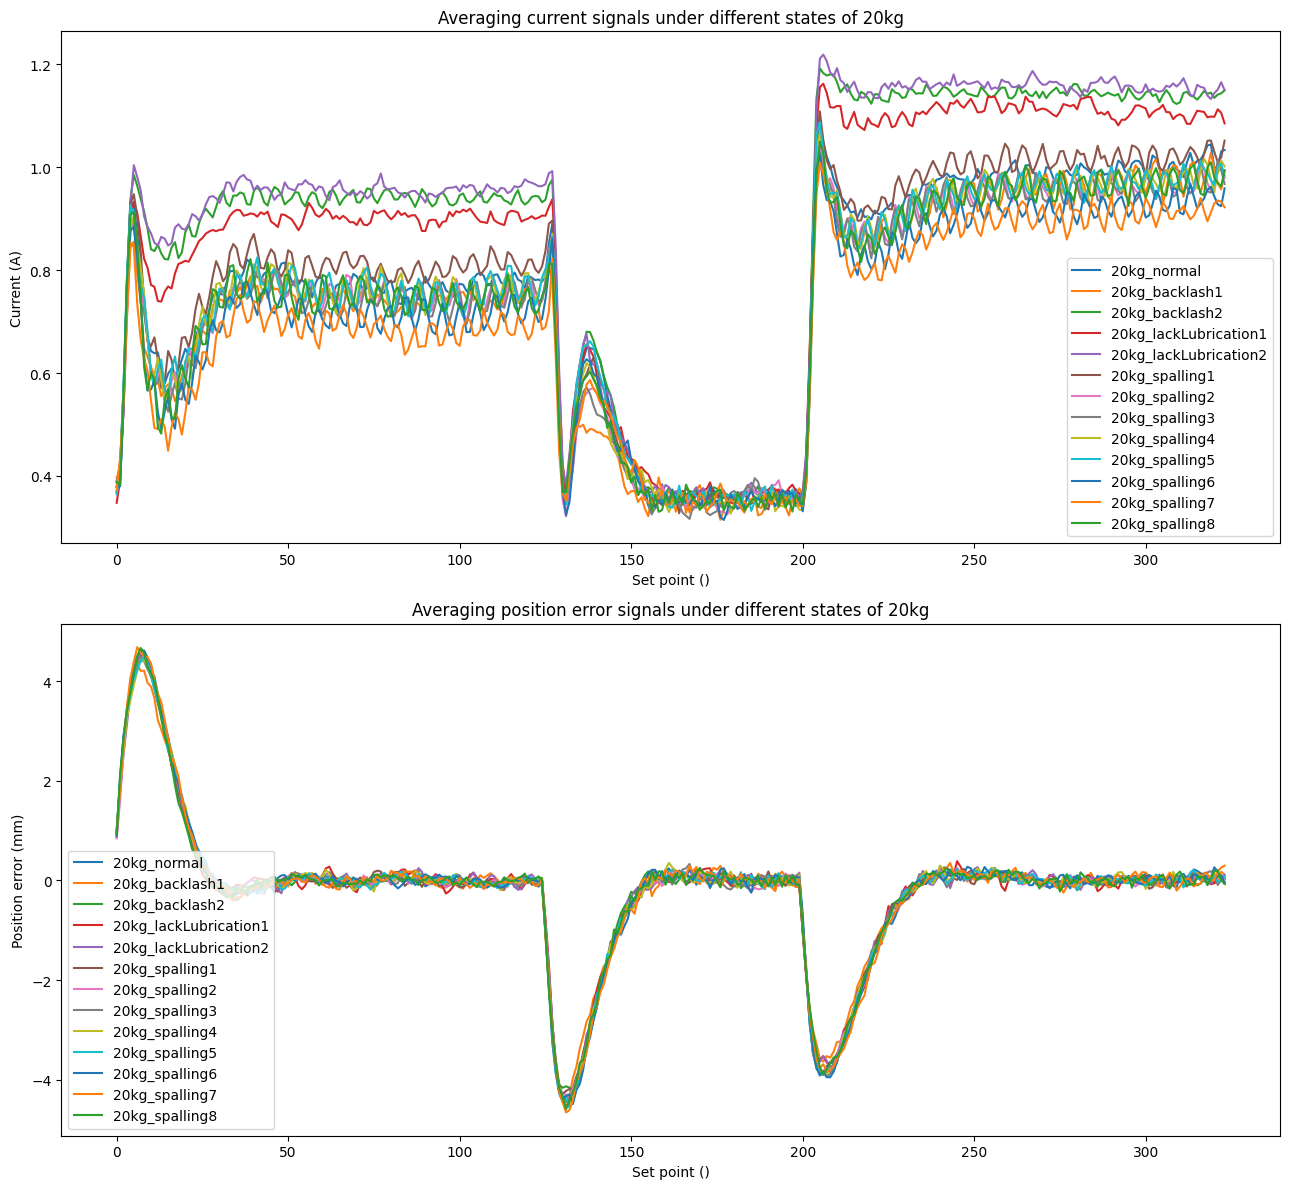

In [103]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 12))

# Plot the first figure on the first subplot (ax1)
ax1.set_title('Averaging current signals under different states of 20kg Savitzky-Golay Filter')
for k, v in average_dict.items():
    ax1.plot(v['current'], label=k)
    ax1.set_xlabel('Set point ()')
    ax1.set_ylabel('Current (A)')
    ax1.legend()

# Plot the second figure on the second subplot (ax2)
ax2.set_title('Averaging position error signals under different states of 20kg Savitzky-Golay Filter')
for k, v in average_dict.items():
    ax2.plot(v['position_error'], label=k)
    ax2.set_xlabel('Set point ()')
    ax2.set_ylabel('Position error (mm)')
    ax2.legend()

plt.tight_layout()

plt.show()

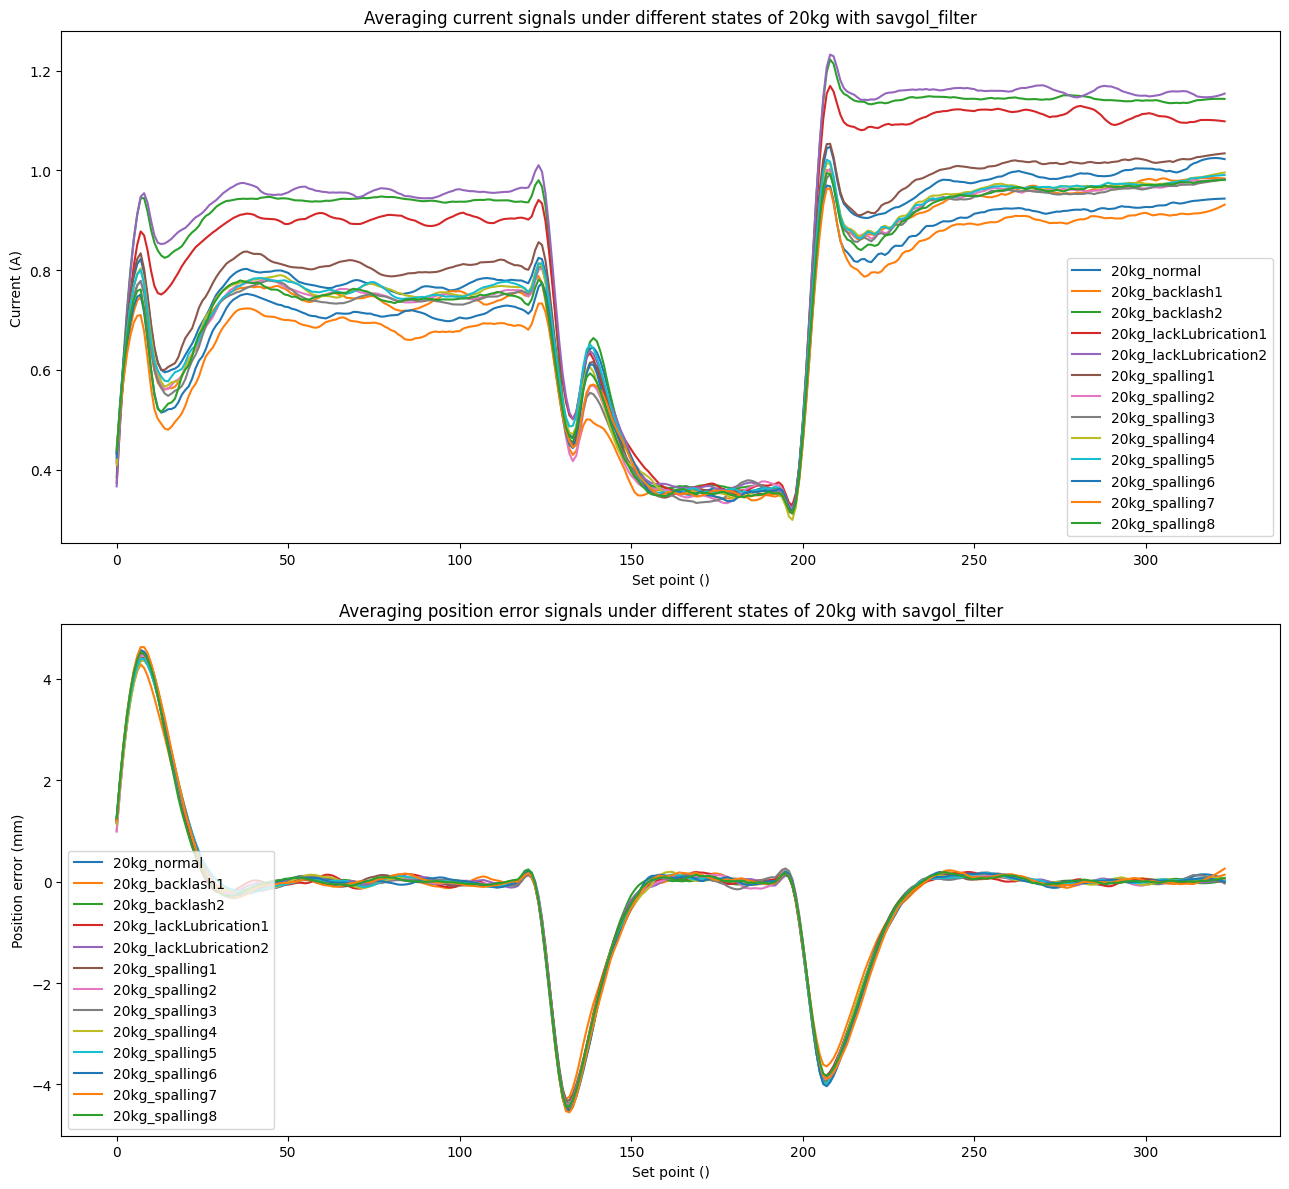

In [106]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 12))

# Plot the first figure on the first subplot (ax1)
ax1.set_title('Averaging current signals under different states of 20kg with savgol_filter')
for k, v in average_dict.items():
    ax1.plot(savgol_filter(v['current'], window_length=15, polyorder=2), label=k)
    ax1.set_xlabel('Set point ()')
    ax1.set_ylabel('Current (A)')
    ax1.legend()

# Plot the second figure on the second subplot (ax2)
ax2.set_title('Averaging position error signals under different states of 20kg with savgol_filter')
for k, v in average_dict.items():
    ax2.plot(savgol_filter(v['position_error'], window_length=15, polyorder=2), label=k)
    ax2.set_xlabel('Set point ()')
    ax2.set_ylabel('Position error (mm)')
    ax2.legend()

plt.tight_layout()

plt.show()

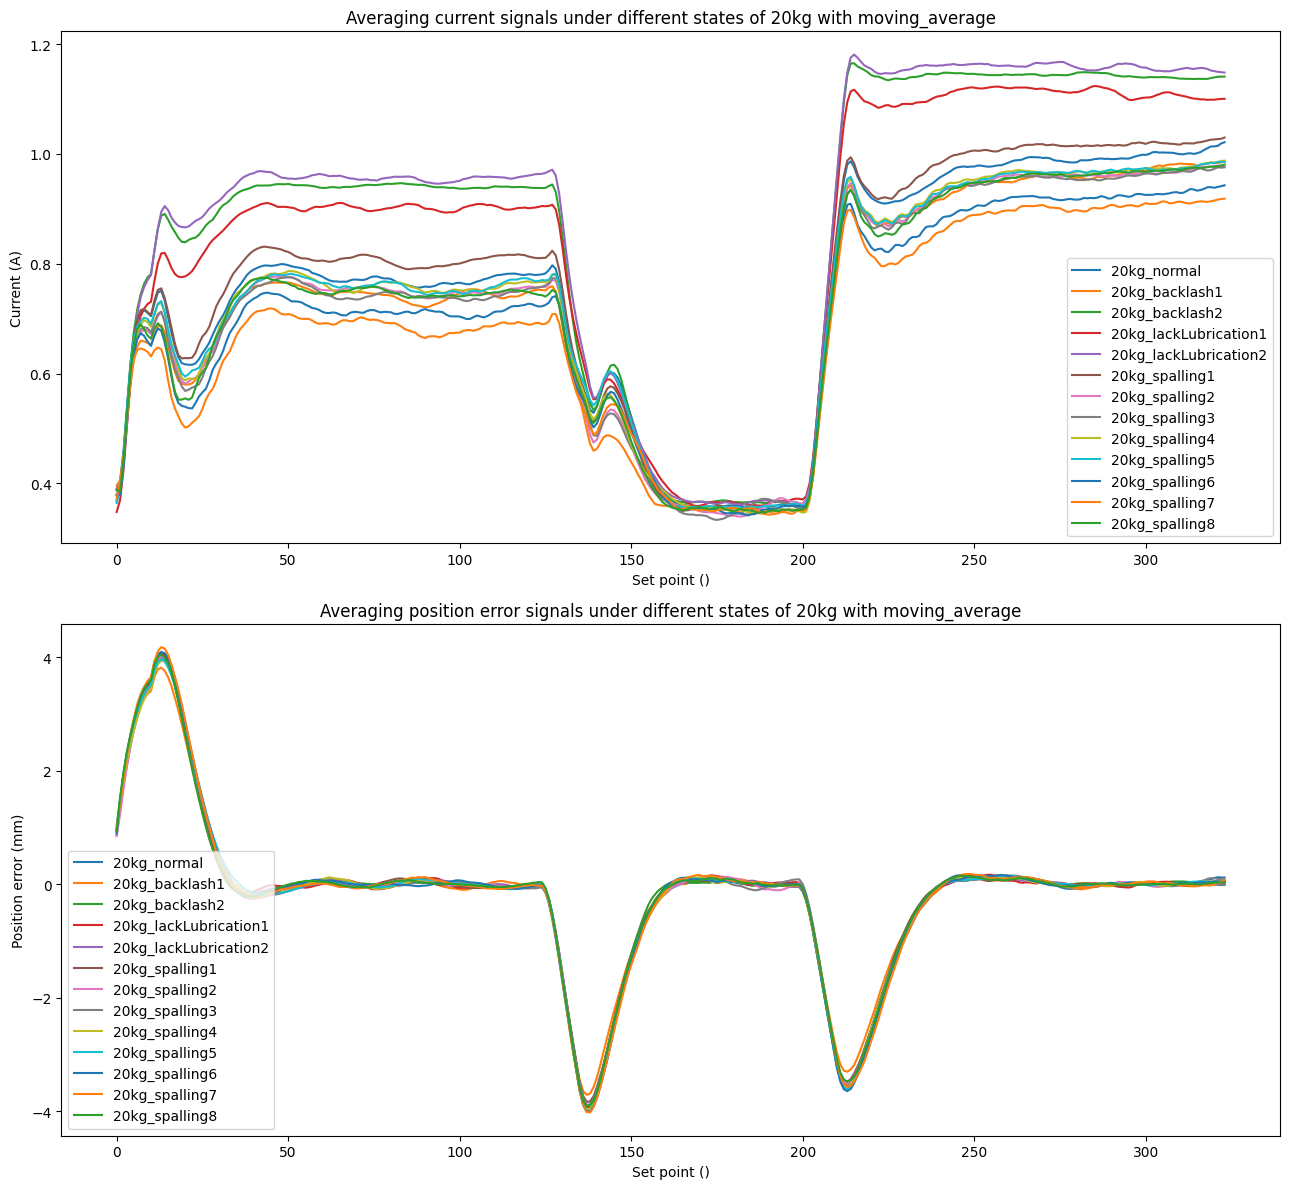

In [108]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 12))

# Plot the first figure on the first subplot (ax1)
ax1.set_title('Averaging current signals under different states of 20kg with moving_average')
for k, v in average_dict.items():
    ax1.plot(moving_average_smoothing(v['current'], SMOOTHING_CUR_WINDOW_SIZE2, tolist=False), label=k)
    ax1.set_xlabel('Set point ()')
    ax1.set_ylabel('Current (A)')
    ax1.legend()

# Plot the second figure on the second subplot (ax2)
ax2.set_title('Averaging position error signals under different states of 20kg with moving_average')
for k, v in average_dict.items():
    ax2.plot(moving_average_smoothing(v['position_error'], SMOOTHING_CUR_WINDOW_SIZE2, tolist=False), label=k)
    ax2.set_xlabel('Set point ()')
    ax2.set_ylabel('Position error (mm)')
    ax2.legend()

plt.tight_layout()

plt.show()